In [1]:
!apt-get -y install fonts-ipafont-gothic --quiet > /dev/null 2>&1

In [2]:
import warnings
warnings.filterwarnings('ignore')

クラスタ 0 の楕円方程式:
中心: (-1.55, 2.75)
長軸: 0.88, 短軸: 0.88
回転角度: -44.71度

クラスタ 1 の楕円方程式:
中心: (1.96, 0.85)
長軸: 0.78, 短軸: 0.82
回転角度: 38.43度

クラスタ 2 の楕円方程式:
中心: (1.05, 4.40)
長軸: 0.85, 短軸: 0.86
回転角度: 43.16度



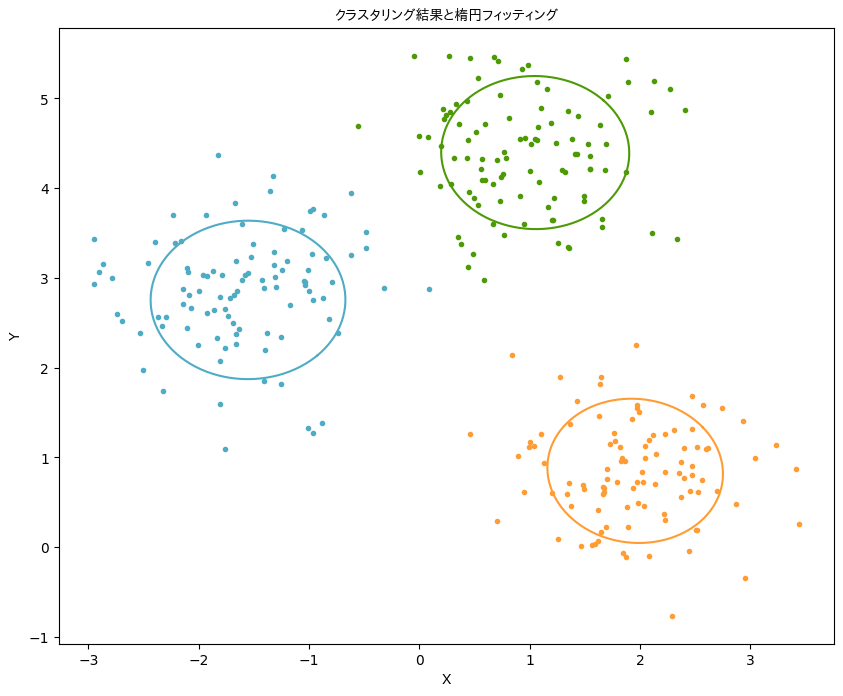

In [3]:
# 1. 最小二乗法による楕円フィッティング
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from scipy.linalg import eigh
import matplotlib.font_manager as fm

font_path = "/usr/share/fonts/opentype/ipafont-gothic/ipagp.ttf"
prop = fm.FontProperties(fname=font_path)

def fit_ellipse(x, y):
    D1 = np.vstack([x**2, x*y, y**2]).T
    D2 = np.vstack([x, y, np.ones(len(x))]).T
    S1 = D1.T @ D1
    S2 = D1.T @ D2
    S3 = D2.T @ D2
    T = -np.linalg.inv(S3) @ S2.T
    M = S1 + S2 @ T
    C = np.array(((0, 0, 2), (0, -1, 0), (2, 0, 0)), dtype=float)
    M = np.linalg.inv(C) @ M
    eigval, eigvec = eigh(M)
    con = 4 * eigvec[0] * eigvec[2] - eigvec[1]**2
    ak = eigvec[:, np.nonzero(con > 0)[0]]
    return np.concatenate((ak, T @ ak)).ravel()

def ellipse_center(a):
    b, c, d, f, g, a = a[1]/2, a[2], a[3]/2, a[4]/2, a[5], a[0]
    num = b*b - a*c
    x0 = (c*d - b*f) / num
    y0 = (a*f - b*d) / num
    return np.array([x0, y0])

def ellipse_angle_of_rotation(a):
    b, c, d, f, g, a = a[1]/2, a[2], a[3]/2, a[4]/2, a[5], a[0]
    return 0.5 * np.arctan(2*b / (a - c))

def ellipse_axis_length(a):
    b, c, d, f, g, a = a[1]/2, a[2], a[3]/2, a[4]/2, a[5], a[0]
    up = 2 * (a*f*f + c*d*d + g*b*b - 2*b*d*f - a*c*g)
    down1 = (b*b - a*c) * ((c - a) * np.sqrt(1 + 4*b*b/((a-c)*(a-c))) - (c+a))
    down2 = (b*b - a*c) * ((a - c) * np.sqrt(1 + 4*b*b/((a-c)*(a-c))) - (c+a))
    res1 = np.sqrt(up / down1)
    res2 = np.sqrt(up / down2)
    return np.array([res1, res2])

# データ生成
X, _ = make_blobs(n_samples=300, centers=3, cluster_std=0.60, random_state=0)

# クラスタリング
kmeans = KMeans(n_clusters=3, random_state=0)
labels = kmeans.fit_predict(X)

# プロット
plt.figure(figsize=(10, 8))
colors = ['#4EACC5', '#FF9C34', '#4E9A06']

for k, col in zip(range(3), colors):
    cluster_data = X[labels == k]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], c=col, marker='.')

    ellipse_params = fit_ellipse(cluster_data[:, 0], cluster_data[:, 1])
    center = ellipse_center(ellipse_params)
    phi = ellipse_angle_of_rotation(ellipse_params)
    axes = ellipse_axis_length(ellipse_params)

    theta = np.linspace(0, 2*np.pi, 200)
    x = center[0] + axes[0] * np.cos(theta) * np.cos(phi) - axes[1] * np.sin(theta) * np.sin(phi)
    y = center[1] + axes[0] * np.cos(theta) * np.sin(phi) + axes[1] * np.sin(theta) * np.cos(phi)
    plt.plot(x, y, c=col)

    print(f"クラスタ {k} の楕円方程式:")
    print(f"中心: ({center[0]:.2f}, {center[1]:.2f})")
    print(f"長軸: {axes[0]:.2f}, 短軸: {axes[1]:.2f}")
    print(f"回転角度: {np.degrees(phi):.2f}度\n")

plt.title('クラスタリング結果と楕円フィッティング', fontproperties=prop)
plt.xlabel('X', fontproperties=prop)
plt.ylabel('Y', fontproperties=prop)
plt.show()

クラスタ 0 の楕円パラメータ:
中心: (-1.65, 2.93)
長軸: 1.41, 短軸: 1.79
回転角度: -61.70度

クラスタ 1 の楕円パラメータ:
中心: (1.96, 0.84)
長軸: 1.45, 短軸: 1.63
回転角度: -95.91度

クラスタ 2 の楕円パラメータ:
中心: (0.96, 4.37)
長軸: 1.66, 短軸: 1.73
回転角度: -144.51度



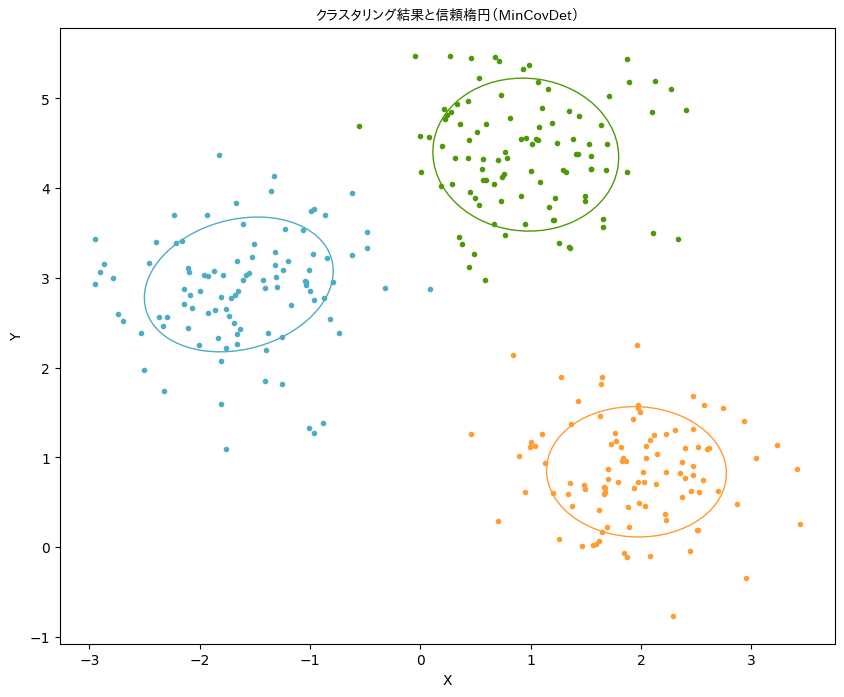

In [4]:
# 2. MinCovDet(最小共分散決定量)による楕円推定
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.covariance import MinCovDet
from matplotlib.patches import Ellipse
import matplotlib.font_manager as fm

font_path = "/usr/share/fonts/opentype/ipafont-gothic/ipagp.ttf"
prop = fm.FontProperties(fname=font_path)

def plot_ellipse(ax, mean, cov, color):
    v, w = np.linalg.eigh(cov)
    u = w[0] / np.linalg.norm(w[0])
    angle = np.arctan2(u[1], u[0])
    angle = 180 * angle / np.pi  # convert to degrees
    v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
    ell = Ellipse(xy=mean, width=v[0], height=v[1], angle=angle,
                  edgecolor=color, fill=False)
    ell.set_clip_box(ax.bbox)
    ell.set_alpha(1)
    ax.add_artist(ell)

# データ生成
X, _ = make_blobs(n_samples=300, centers=3, cluster_std=0.60, random_state=0)

# クラスタリング
kmeans = KMeans(n_clusters=3, random_state=0)
labels = kmeans.fit_predict(X)

# プロット
fig, ax = plt.subplots(figsize=(10, 8))
colors = ['#4EACC5', '#FF9C34', '#4E9A06']

for k, col in zip(range(3), colors):
    cluster_data = X[labels == k]
    ax.scatter(cluster_data[:, 0], cluster_data[:, 1], c=col, marker='.')

    mcd = MinCovDet(support_fraction=1.0).fit(cluster_data)
    mean = mcd.location_
    cov = mcd.covariance_

    plot_ellipse(ax, mean, cov, col)

    v, w = np.linalg.eigh(cov)
    v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
    print(f"クラスタ {k} の楕円パラメータ:")
    print(f"中心: ({mean[0]:.2f}, {mean[1]:.2f})")
    print(f"長軸: {v[0]:.2f}, 短軸: {v[1]:.2f}")
    print(f"回転角度: {180 * np.arctan2(w[0][1], w[0][0]) / np.pi:.2f}度\n")

ax.set_title('クラスタリング結果と信頼楕円（MinCovDet）', fontproperties=prop)
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.show()

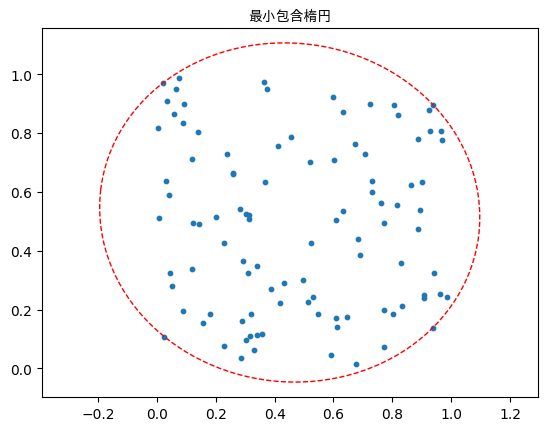

In [5]:
# 3. 最小包含楕円(Minimum Enclosing Ellipse)
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv, eig
from matplotlib.patches import Ellipse
import matplotlib.font_manager as fm

font_path = "/usr/share/fonts/opentype/ipafont-gothic/ipagp.ttf"
prop = fm.FontProperties(fname=font_path)

def min_enclosing_ellipse(P, tol=1e-5):
    N, d = P.shape
    Q = np.column_stack((P, np.ones(N)))
    err = tol + 1.0
    u = np.ones(N) / N

    while err > tol:
        X = Q.T @ np.diag(u) @ Q
        M = np.diag(Q @ inv(X) @ Q.T)
        j = np.argmax(M)
        step_size = (M[j] - d - 1) / ((d + 1) * (M[j] - 1))
        new_u = (1 - step_size) * u
        new_u[j] += step_size
        err = np.linalg.norm(new_u - u)
        u = new_u

    center = P.T @ u
    A = inv(P.T @ np.diag(u) @ P - np.outer(center, center)) / d
    return center, A

def plot_enclosing_ellipse(ax, center, A, color='black'):
    vals, vecs = eig(A)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]

    width, height = 2 / np.sqrt(vals)
    angle = np.degrees(np.arctan2(*vecs[:, 0][::-1]))

    ellipse = Ellipse(xy=center, width=width, height=height, angle=angle,
                      edgecolor=color, fill=False, linestyle='--')
    ax.add_patch(ellipse)

# ランダムな点群
np.random.seed(42)
X = np.random.rand(100, 2)

fig, ax = plt.subplots()
ax.scatter(X[:, 0], X[:, 1], s=10)

center, A = min_enclosing_ellipse(X)
plot_enclosing_ellipse(ax, center, A, color='red')

ax.set_title('最小包含楕円', fontproperties=prop)
plt.axis('equal')
plt.show()